In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### Episode Generation

In [3]:
def generate_episode(env, policy, epsilon=0.1):
    """
    Generate a complete episode following epsilon-greedy policy.

    Args:
        env: Gymnasium Blackjack environment
        policy: Dictionary mapping states to best actions (greedy action)
        epsilon: Exploration rate for epsilon-greedy

    Returns:
        states: List of states visited
        actions: List of actions taken
        rewards: List of rewards received
    """
    states, actions, rewards = [], [], []

    # Reset environment to start new episode
    state, _ = env.reset()
    terminated = False

    while not terminated:
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()  # Random action (explore)
        else:
            action = policy.get(state, env.action_space.sample())  # Greedy action (exploit)

        # Take action and observe result
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Store trajectory
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards

### Return Computation Function

In [4]:
def compute_returns(rewards, gamma=1.0):
    """
    Compute discounted returns for each time step in an episode.

    Args:
        rewards: List of rewards from episode
        gamma: Discount factor

    Returns:
        returns: List of discounted returns G_t for each time step
    """
    returns = []
    G = 0

    # Work backward through episode
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    return returns

### First-Visit Monte Carlo Control Algorithm

In [5]:
def mc_control_first_visit(env, num_episodes=500000, epsilon_start=1.0,
                           epsilon_end=0.01, epsilon_decay=0.99999, gamma=1.0):
    """
    First-visit Monte Carlo control with epsilon-greedy policy.

    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to train
        epsilon_start: Initial exploration rate
        epsilon_end: Minimum exploration rate
        epsilon_decay: Decay rate for epsilon
        gamma: Discount factor

    Returns:
        Q: Action-value function
        policy: Learned policy
        stats: Training statistics
    """
    # Initialize Q(s,a) and tracking structures
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    policy = {}

    # Statistics tracking
    episode_returns = []
    episode_lengths = []
    epsilon_values = []

    epsilon = epsilon_start

    print("Starting Monte Carlo Control Training...")
    print(f"Episodes: {num_episodes}, Initial ε: {epsilon_start}, Final ε: {epsilon_end}")

    for episode in tqdm(range(num_episodes), desc="Training"):
        # Generate episode using current epsilon-greedy policy
        states, actions, rewards = generate_episode(env, policy, epsilon)

        # Track statistics
        episode_returns.append(sum(rewards))
        episode_lengths.append(len(states))
        epsilon_values.append(epsilon)

        # First-visit MC update
        G = 0
        visited_pairs = set()

        # Process episode backward
        for t in range(len(states) - 1, -1, -1):
            s, a = states[t], actions[t]
            r = rewards[t]

            # Compute return
            G = r + gamma * G

            # First-visit check
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a))

                # Incremental update of Q(s,a)
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1
                Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]

        # Policy improvement: Make policy greedy w.r.t. Q
        for s in set(states):
            policy[s] = np.argmax(Q[s])

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Progress reporting
        if (episode + 1) % 50000 == 0:
            avg_return = np.mean(episode_returns[-10000:])
            print(f"\nEpisode {episode + 1:,}")
            print(f"  Avg Return (last 10k): {avg_return:.3f}")
            print(f"  Current ε: {epsilon:.4f}")
            print(f"  States visited: {len(Q)}")

    stats = {
        'episode_returns': episode_returns,
        'episode_lengths': episode_lengths,
        'epsilon_values': epsilon_values
    }

    print("\nTraining Complete!")
    print(f"Total states visited: {len(Q)}")
    print(f"Final average return: {np.mean(episode_returns[-10000:]):.3f}")

    return Q, policy, stats

In [6]:
env = gym.make('Blackjack-v1', natural=False, sab=False)

print("Environment Details:")
print(f"  State space: (player_sum [4-21], dealer_card [1-10], usable_ace [0,1])")
print(f"  Action space: {env.action_space} (0=stick, 1=hit)")
print(f"  Rewards: +1 (win), 0 (draw), -1 (loss)")
print()

Environment Details:
  State space: (player_sum [4-21], dealer_card [1-10], usable_ace [0,1])
  Action space: Discrete(2) (0=stick, 1=hit)
  Rewards: +1 (win), 0 (draw), -1 (loss)



In [7]:
# Train the agent
Q, policy, stats = mc_control_first_visit(
    env,
    num_episodes=500000,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.99999,
    gamma=1.0
)

Starting Monte Carlo Control Training...
Episodes: 500000, Initial ε: 1.0, Final ε: 0.01


Training:  10%|█         | 51330/500000 [00:07<00:59, 7481.54it/s]


Episode 50,000
  Avg Return (last 10k): -0.276
  Current ε: 0.6065
  States visited: 280


Training:  20%|██        | 100529/500000 [00:14<01:26, 4597.04it/s]


Episode 100,000
  Avg Return (last 10k): -0.202
  Current ε: 0.3679
  States visited: 280


Training:  30%|███       | 151045/500000 [00:21<00:46, 7534.70it/s]


Episode 150,000
  Avg Return (last 10k): -0.145
  Current ε: 0.2231
  States visited: 280


Training:  40%|████      | 201279/500000 [00:29<00:40, 7415.09it/s]


Episode 200,000
  Avg Return (last 10k): -0.103
  Current ε: 0.1353
  States visited: 280


Training:  50%|█████     | 251465/500000 [00:36<00:32, 7531.67it/s]


Episode 250,000
  Avg Return (last 10k): -0.082
  Current ε: 0.0821
  States visited: 280


Training:  60%|██████    | 301375/500000 [00:43<00:26, 7575.01it/s]


Episode 300,000
  Avg Return (last 10k): -0.072
  Current ε: 0.0498
  States visited: 280


Training:  70%|███████   | 350574/500000 [00:50<00:26, 5587.62it/s]


Episode 350,000
  Avg Return (last 10k): -0.083
  Current ε: 0.0302
  States visited: 280


Training:  80%|████████  | 401469/500000 [00:57<00:13, 7274.56it/s]


Episode 400,000
  Avg Return (last 10k): -0.072
  Current ε: 0.0183
  States visited: 280


Training:  90%|█████████ | 451423/500000 [01:05<00:06, 7219.32it/s]


Episode 450,000
  Avg Return (last 10k): -0.074
  Current ε: 0.0111
  States visited: 280


Training: 100%|██████████| 500000/500000 [01:11<00:00, 6983.08it/s]


Episode 500,000
  Avg Return (last 10k): -0.067
  Current ε: 0.0100
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.067


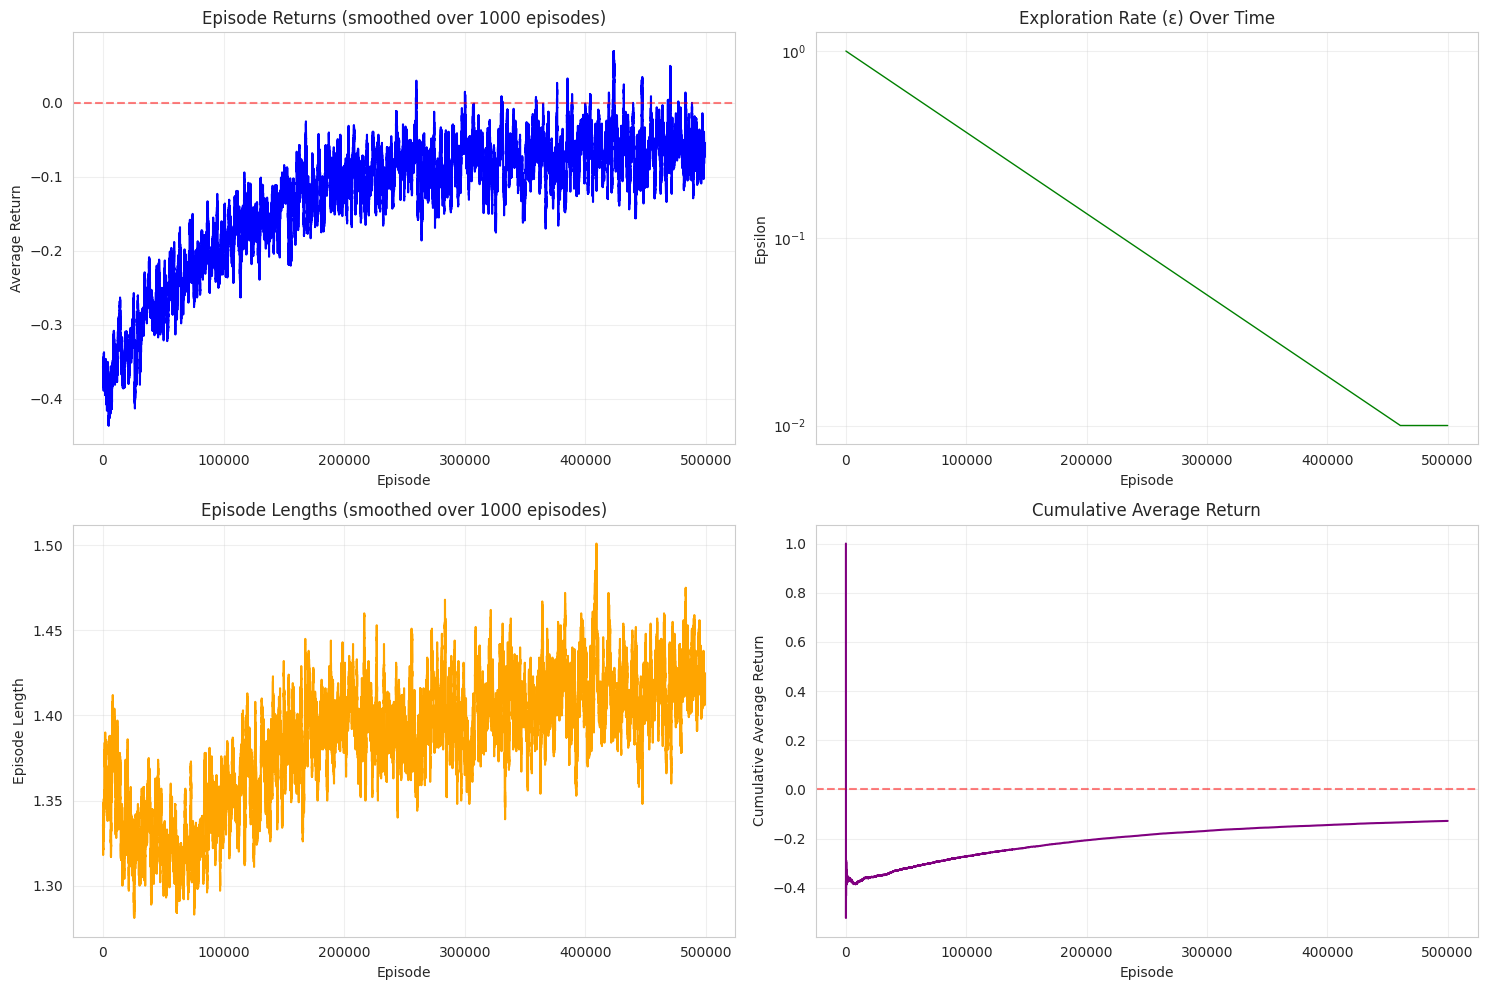

Final Training Statistics:
  Final 10k episodes avg return: -0.067
  Best 10k window avg return: -0.045
  Overall average return: -0.128


In [8]:
def plot_learning_curves(stats, window=1000):
    """Plot training statistics with smoothing."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Smooth function
    def smooth(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    episode_returns = stats['episode_returns']
    episode_lengths = stats['episode_lengths']
    epsilon_values = stats['epsilon_values']

    # Plot 1: Episode Returns (smoothed)
    ax = axes[0, 0]
    smoothed_returns = smooth(episode_returns, window)
    ax.plot(smoothed_returns, linewidth=1.5, color='blue')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Return')
    ax.set_title(f'Episode Returns (smoothed over {window} episodes)')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Plot 2: Epsilon Decay
    ax = axes[0, 1]
    ax.plot(epsilon_values, linewidth=1, color='green')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Epsilon')
    ax.set_title('Exploration Rate (ε) Over Time')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # Plot 3: Episode Lengths
    ax = axes[1, 0]
    smoothed_lengths = smooth(episode_lengths, window)
    ax.plot(smoothed_lengths, linewidth=1.5, color='orange')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Episode Length')
    ax.set_title(f'Episode Lengths (smoothed over {window} episodes)')
    ax.grid(True, alpha=0.3)

    # Plot 4: Cumulative Average Return
    ax = axes[1, 1]
    cumulative_avg = np.cumsum(episode_returns) / (np.arange(len(episode_returns)) + 1)
    ax.plot(cumulative_avg, linewidth=1.5, color='purple')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Return')
    ax.set_title('Cumulative Average Return')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("Final Training Statistics:")
    print(f"  Final 10k episodes avg return: {np.mean(episode_returns[-10000:]):.3f}")
    print(f"  Best 10k window avg return: {max([np.mean(episode_returns[i:i+10000]) for i in range(0, len(episode_returns)-10000, 10000)]):.3f}")
    print(f"  Overall average return: {np.mean(episode_returns):.3f}")

plot_learning_curves(stats, window=1000)

In [9]:
def get_value_function(Q):
    """
    Extract state-value function V(s) from action-value function Q(s,a).
    V(s) = max_a Q(s,a)
    """
    V = {}
    for state in Q:
        V[state] = np.max(Q[state])
    return V

def get_policy_from_Q(Q):
    """Extract deterministic greedy policy from Q."""
    policy = {}
    for state in Q:
        policy[state] = np.argmax(Q[state])
    return policy

V = get_value_function(Q)
greedy_policy = get_policy_from_Q(Q)

print(f"Value function computed for {len(V)} states")
print(f"Policy extracted for {len(greedy_policy)} states")

Value function computed for 280 states
Policy extracted for 280 states


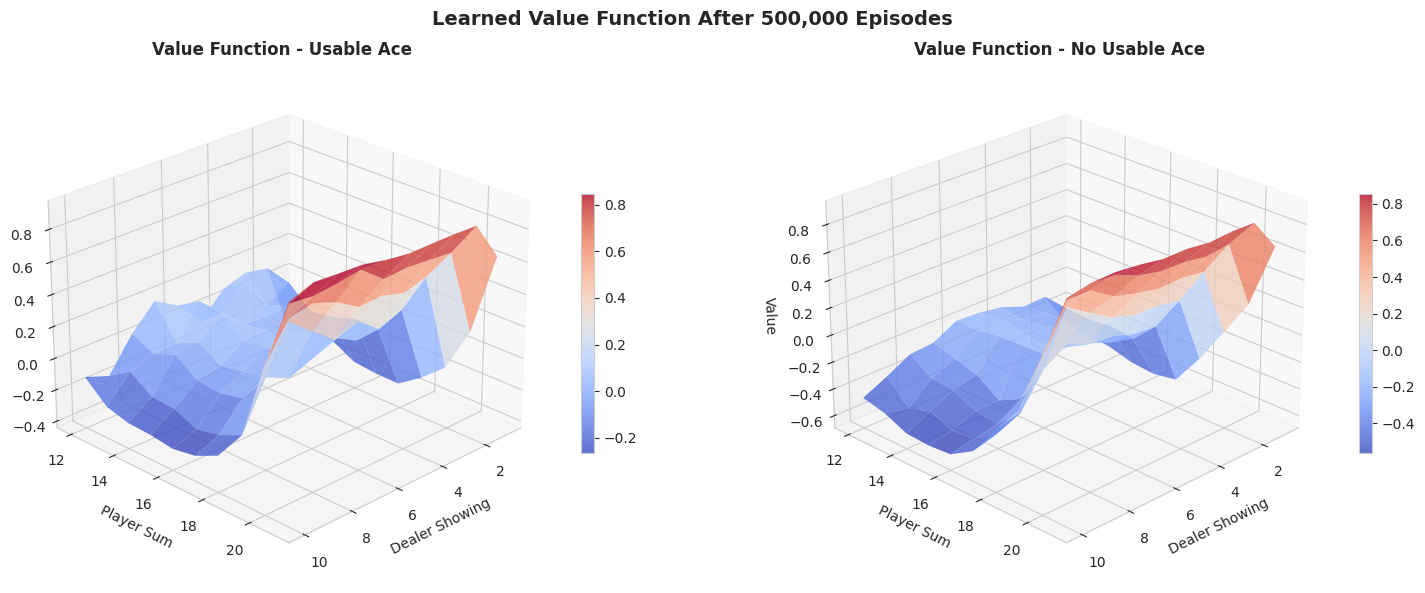

In [10]:
def plot_value_function_3d(V, title="Value Function"):
    """
    Create 3D surface plots for value function.
    Separate plots for usable and non-usable ace.
    """
    # Prepare data for both ace cases
    def get_Z(usable_ace):
        """Get value grid for specific ace case."""
        player_range = range(12, 22)  # Player sum 12-21
        dealer_range = range(1, 11)   # Dealer showing 1-10

        Z = np.zeros((len(player_range), len(dealer_range)))

        for i, player in enumerate(player_range):
            for j, dealer in enumerate(dealer_range):
                state = (player, dealer, usable_ace)
                Z[i, j] = V.get(state, 0)

        return Z

    fig = plt.figure(figsize=(16, 6))

    # Plot for usable ace
    ax1 = fig.add_subplot(121, projection='3d')
    player_range = np.arange(12, 22)
    dealer_range = np.arange(1, 11)
    X, Y = np.meshgrid(dealer_range, player_range)
    Z1 = get_Z(True)

    surf1 = ax1.plot_surface(X, Y, Z1, cmap=cm.coolwarm, alpha=0.8,
                             linewidth=0, antialiased=True)
    ax1.set_xlabel('Dealer Showing', fontsize=10)
    ax1.set_ylabel('Player Sum', fontsize=10)
    ax1.set_zlabel('Value', fontsize=10)
    ax1.set_title('Value Function - Usable Ace', fontsize=12, fontweight='bold')
    ax1.view_init(elev=25, azim=45)
    fig.colorbar(surf1, ax=ax1, shrink=0.5)

    # Plot for non-usable ace
    ax2 = fig.add_subplot(122, projection='3d')
    Z2 = get_Z(False)

    surf2 = ax2.plot_surface(X, Y, Z2, cmap=cm.coolwarm, alpha=0.8,
                             linewidth=0, antialiased=True)
    ax2.set_xlabel('Dealer Showing', fontsize=10)
    ax2.set_ylabel('Player Sum', fontsize=10)
    ax2.set_zlabel('Value', fontsize=10)
    ax2.set_title('Value Function - No Usable Ace', fontsize=12, fontweight='bold')
    ax2.view_init(elev=25, azim=45)
    fig.colorbar(surf2, ax=ax2, shrink=0.5)

    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

plot_value_function_3d(V, "Learned Value Function After 500,000 Episodes")

/tmp/ipython-input-1026087620.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


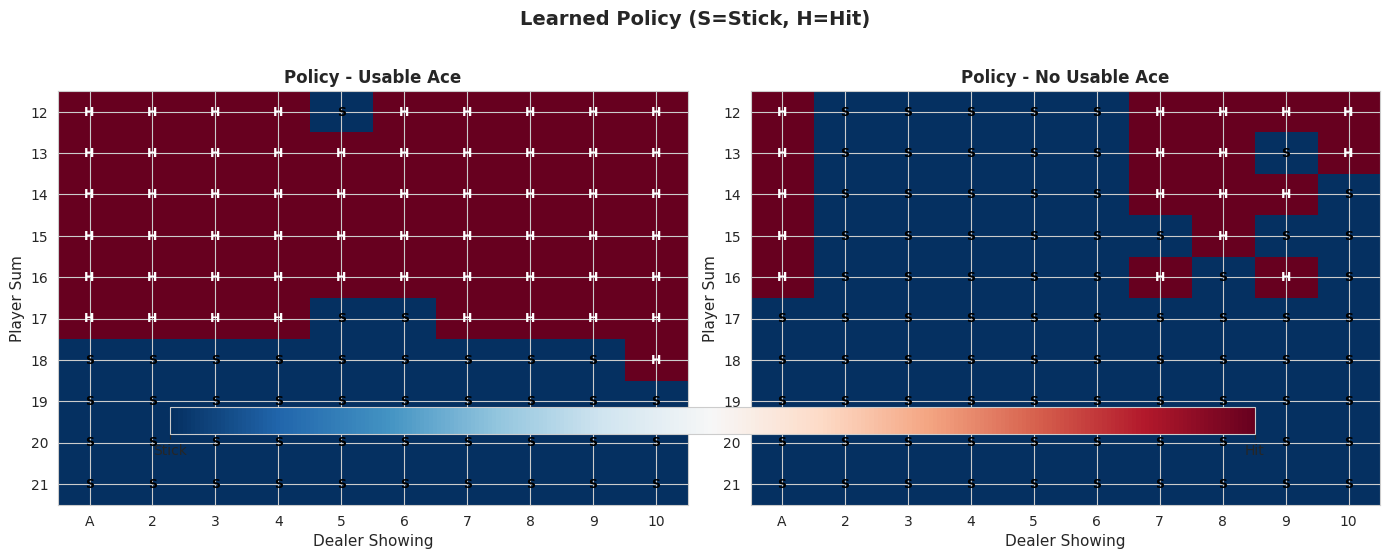

In [11]:
def plot_policy(policy, title="Learned Policy"):
    """
    Visualize the learned policy as heatmaps.
    0 = Stick (blue), 1 = Hit (red)
    """
    def get_policy_grid(usable_ace):
        """Get policy grid for specific ace case."""
        player_range = range(12, 22)
        dealer_range = range(1, 11)

        grid = np.zeros((len(player_range), len(dealer_range)))

        for i, player in enumerate(player_range):
            for j, dealer in enumerate(dealer_range):
                state = (player, dealer, usable_ace)
                grid[i, j] = policy.get(state, 0)

        return grid

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Usable ace
    ax = axes[0]
    grid1 = get_policy_grid(True)
    im1 = ax.imshow(grid1, cmap='RdBu_r', aspect='auto', vmin=0, vmax=1)
    ax.set_xlabel('Dealer Showing', fontsize=11)
    ax.set_ylabel('Player Sum', fontsize=11)
    ax.set_title('Policy - Usable Ace', fontsize=12, fontweight='bold')
    ax.set_xticks(range(10))
    ax.set_xticklabels(['A'] + list(range(2, 11)))
    ax.set_yticks(range(10))
    ax.set_yticklabels(range(12, 22))

    # Add text annotations
    for i in range(10):
        for j in range(10):
            text = 'H' if grid1[i, j] == 1 else 'S'
            ax.text(j, i, text, ha="center", va="center",
                   color="white" if grid1[i, j] == 1 else "black", fontsize=9, fontweight='bold')

    # No usable ace
    ax = axes[1]
    grid2 = get_policy_grid(False)
    im2 = ax.imshow(grid2, cmap='RdBu_r', aspect='auto', vmin=0, vmax=1)
    ax.set_xlabel('Dealer Showing', fontsize=11)
    ax.set_ylabel('Player Sum', fontsize=11)
    ax.set_title('Policy - No Usable Ace', fontsize=12, fontweight='bold')
    ax.set_xticks(range(10))
    ax.set_xticklabels(['A'] + list(range(2, 11)))
    ax.set_yticks(range(10))
    ax.set_yticklabels(range(12, 22))

    # Add text annotations
    for i in range(10):
        for j in range(10):
            text = 'H' if grid2[i, j] == 1 else 'S'
            ax.text(j, i, text, ha="center", va="center",
                   color="white" if grid2[i, j] == 1 else "black", fontsize=9, fontweight='bold')

    # Add colorbar
    cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', pad=0.1, aspect=40)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Stick', 'Hit'])

    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_policy(greedy_policy, "Learned Policy (S=Stick, H=Hit)")

### Compare with Basic Blackjack Strategy

In [12]:
def basic_blackjack_strategy(state):
    """
    Basic strategy for Blackjack (simplified version).
    Returns action: 0=stick, 1=hit
    """
    player_sum, dealer_card, usable_ace = state

    if usable_ace:
        # Soft hands (usable ace)
        if player_sum >= 19:
            return 0  # Stick
        elif player_sum == 18:
            return 0 if dealer_card in [2, 7, 8] else 1
        else:
            return 1  # Hit
    else:
        # Hard hands (no usable ace)
        if player_sum >= 17:
            return 0  # Stick
        elif player_sum >= 13:
            return 0 if dealer_card in [2, 3, 4, 5, 6] else 1
        else:
            return 1  # Hit


In [13]:
def compare_policies(learned_policy, basic_strategy):
    """Compare learned policy with basic strategy."""
    agreements = 0
    disagreements = 0

    comparison = []

    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            for usable_ace in [True, False]:
                state = (player_sum, dealer_card, usable_ace)

                learned_action = learned_policy.get(state, 1)
                basic_action = basic_strategy(state)

                if learned_action == basic_action:
                    agreements += 1
                else:
                    disagreements += 1
                    comparison.append({
                        'state': state,
                        'learned': 'Hit' if learned_action == 1 else 'Stick',
                        'basic': 'Hit' if basic_action == 1 else 'Stick'
                    })

    total = agreements + disagreements
    agreement_pct = 100 * agreements / total

    print("Policy Comparison: Learned vs Basic Strategy")
    print("=" * 50)
    print(f"Total states compared: {total}")
    print(f"Agreements: {agreements} ({agreement_pct:.1f}%)")
    print(f"Disagreements: {disagreements} ({100-agreement_pct:.1f}%)")
    print()

    if disagreements > 0 and disagreements <= 20:
        print("States where policies differ:")
        for item in comparison[:20]:
            s = item['state']
            print(f"  {s}: Learned={item['learned']}, Basic={item['basic']}")

    return agreement_pct

agreement = compare_policies(greedy_policy, basic_blackjack_strategy)

Policy Comparison: Learned vs Basic Strategy
Total states compared: 200
Agreements: 179 (89.5%)
Disagreements: 21 (10.5%)



In [14]:
def evaluate_policy(env, policy, num_episodes=10000, epsilon=0.0):
    """
    Evaluate policy over multiple episodes.

    Args:
        env: Gymnasium environment
        policy: Policy dictionary
        num_episodes: Number of evaluation episodes
        epsilon: Exploration rate (0 for pure exploitation)
    """
    total_rewards = []
    wins = 0
    losses = 0
    draws = 0

    for _ in tqdm(range(num_episodes), desc="Evaluating"):
        states, actions, rewards = generate_episode(env, policy, epsilon)
        total_reward = sum(rewards)
        total_rewards.append(total_reward)

        if total_reward > 0:
            wins += 1
        elif total_reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = np.mean(total_rewards)
    win_rate = 100 * wins / num_episodes
    loss_rate = 100 * losses / num_episodes
    draw_rate = 100 * draws / num_episodes

    print(f"\nPolicy Evaluation Results ({num_episodes} episodes):")
    print("=" * 50)
    print(f"Average Reward: {avg_reward:.4f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Loss Rate: {loss_rate:.2f}%")
    print(f"Draw Rate: {draw_rate:.2f}%")
    print(f"Standard Deviation: {np.std(total_rewards):.4f}")

    return total_rewards, avg_reward, win_rate

Evaluating: 100%|██████████| 10000/10000 [00:01<00:00, 8830.84it/s]



Policy Evaluation Results (10000 episodes):
Average Reward: -0.0575
Win Rate: 42.74%
Loss Rate: 48.49%
Draw Rate: 8.77%
Standard Deviation: 0.9534


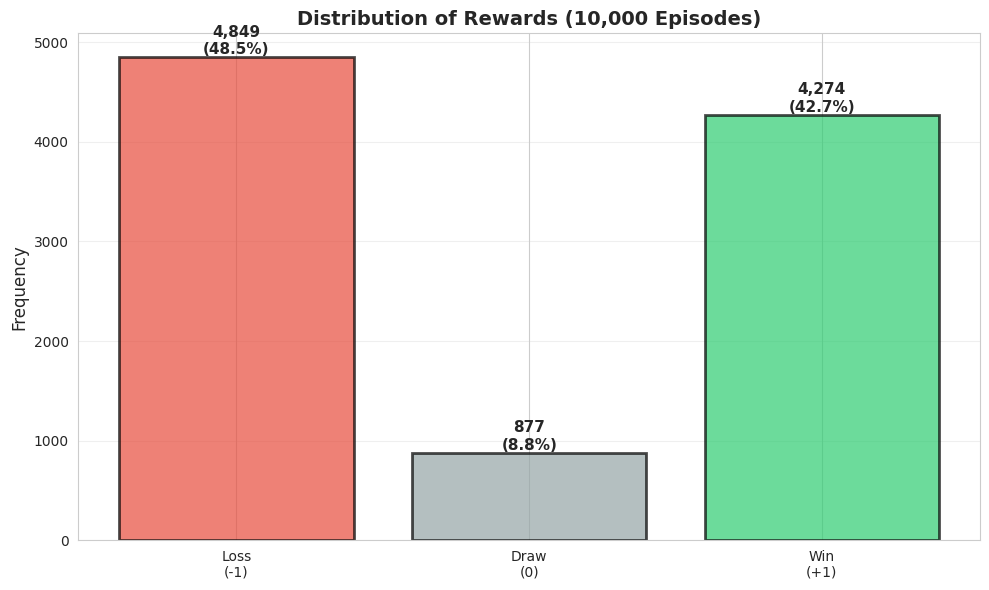

In [15]:
# Evaluate learned policy
rewards, avg_reward, win_rate = evaluate_policy(env, greedy_policy, num_episodes=10000)

# Plot reward distribution
plt.figure(figsize=(10, 6))

# Count outcomes
losses = rewards.count(-1)
draws = rewards.count(0)
wins = rewards.count(1)

# Create bar chart
outcomes = ['Loss\n(-1)', 'Draw\n(0)', 'Win\n(+1)']
counts = [losses, draws, wins]
colors = ['#e74c3c', '#95a5a6', '#2ecc71']

bars = plt.bar(outcomes, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({100*count/10000:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Rewards (10,000 Episodes)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Experiment with Different Epsilon Values

Experimenting with different epsilon values...

Training with ε = 0.01
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 0.01, Final ε: 0.01


Training:  51%|█████     | 50940/100000 [00:06<00:08, 5496.41it/s]


Episode 50,000
  Avg Return (last 10k): -0.128
  Current ε: 0.0100
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7424.17it/s]



Episode 100,000
  Avg Return (last 10k): -0.115
  Current ε: 0.0100
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.115


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 8945.90it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0972
Win Rate: 41.34%
Loss Rate: 51.06%
Draw Rate: 7.60%
Standard Deviation: 0.9563

Training with ε = 0.05
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 0.05, Final ε: 0.05


Training:  51%|█████     | 50892/100000 [00:07<00:06, 7546.89it/s]


Episode 50,000
  Avg Return (last 10k): -0.111
  Current ε: 0.0500
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7205.11it/s]



Episode 100,000
  Avg Return (last 10k): -0.080
  Current ε: 0.0500
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.080


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 9208.65it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0548
Win Rate: 43.06%
Loss Rate: 48.54%
Draw Rate: 8.40%
Standard Deviation: 0.9555

Training with ε = 0.1
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 0.1, Final ε: 0.1


Training:  51%|█████     | 51162/100000 [00:07<00:06, 7551.02it/s]


Episode 50,000
  Avg Return (last 10k): -0.103
  Current ε: 0.1000
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7143.80it/s]



Episode 100,000
  Avg Return (last 10k): -0.102
  Current ε: 0.1000
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.102


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 5957.51it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0654
Win Rate: 42.30%
Loss Rate: 48.84%
Draw Rate: 8.86%
Standard Deviation: 0.9524

Training with ε = 0.2
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 0.2, Final ε: 0.2


Training:  51%|█████▏    | 51443/100000 [00:07<00:06, 7787.48it/s]


Episode 50,000
  Avg Return (last 10k): -0.130
  Current ε: 0.2000
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:14<00:00, 7052.80it/s]



Episode 100,000
  Avg Return (last 10k): -0.126
  Current ε: 0.2000
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.126


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 8683.94it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0530
Win Rate: 42.94%
Loss Rate: 48.24%
Draw Rate: 8.82%
Standard Deviation: 0.9534


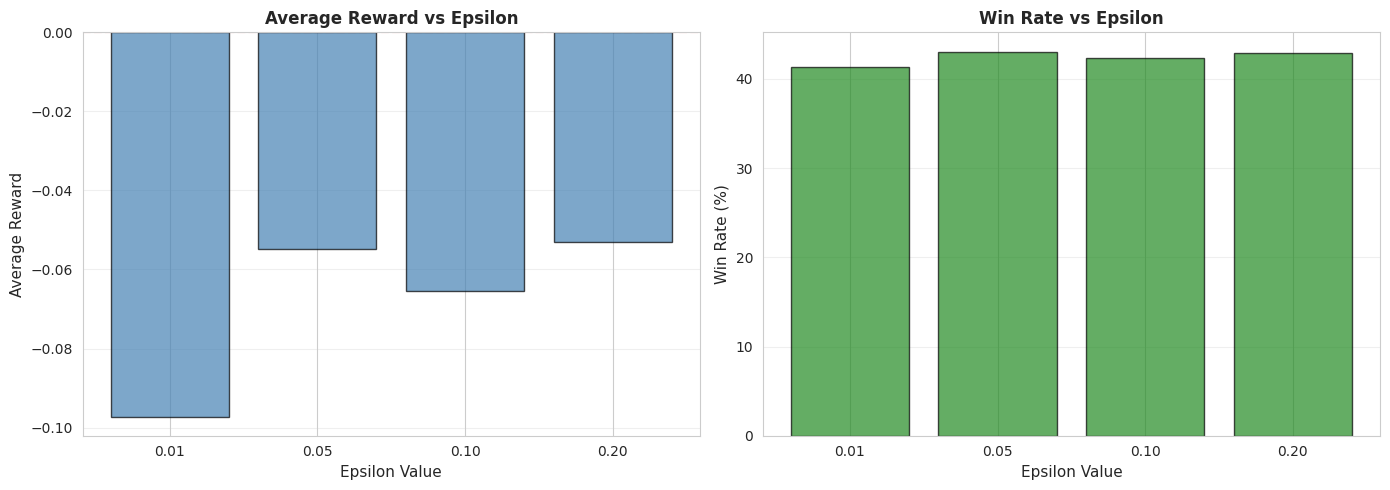

In [16]:
def experiment_epsilon_values(env, epsilon_values, num_episodes=100000):
    """
    Train with different epsilon values and compare results.
    """
    results = {}

    print("Experimenting with different epsilon values...")
    print("=" * 60)

    for eps in epsilon_values:
        print(f"\nTraining with ε = {eps}")

        Q_temp, policy_temp, stats_temp = mc_control_first_visit(
            env,
            num_episodes=num_episodes,
            epsilon_start=eps,
            epsilon_end=eps,  # Fixed epsilon (no decay)
            epsilon_decay=1.0,
            gamma=1.0
        )

        # Evaluate
        rewards_temp, avg_reward_temp, win_rate_temp = evaluate_policy(
            env, policy_temp, num_episodes=5000, epsilon=0.0
        )

        results[eps] = {
            'avg_reward': avg_reward_temp,
            'win_rate': win_rate_temp,
            'final_returns': stats_temp['episode_returns'][-10000:]
        }

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Average Reward
    ax = axes[0]
    eps_list = list(results.keys())
    avg_rewards = [results[e]['avg_reward'] for e in eps_list]
    ax.bar(range(len(eps_list)), avg_rewards, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Epsilon Value', fontsize=11)
    ax.set_ylabel('Average Reward', fontsize=11)
    ax.set_title('Average Reward vs Epsilon', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(eps_list)))
    ax.set_xticklabels([f'{e:.2f}' for e in eps_list])
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Plot 2: Win Rate
    ax = axes[1]
    win_rates = [results[e]['win_rate'] for e in eps_list]
    ax.bar(range(len(eps_list)), win_rates, color='forestgreen', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Epsilon Value', fontsize=11)
    ax.set_ylabel('Win Rate (%)', fontsize=11)
    ax.set_title('Win Rate vs Epsilon', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(eps_list)))
    ax.set_xticklabels([f'{e:.2f}' for e in eps_list])
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return results

# Run experiment
epsilon_experiments = [0.01, 0.05, 0.1, 0.2]
epsilon_results = experiment_epsilon_values(env, epsilon_experiments, num_episodes=100000)

### Experiment with Epsilon Decay Schedules

Experimenting with different decay schedules...

Training with Fast Decay
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 1.0, Final ε: 0.01


Training:  51%|█████     | 50911/100000 [00:07<00:06, 7639.89it/s]


Episode 50,000
  Avg Return (last 10k): -0.069
  Current ε: 0.0100
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7303.23it/s]



Episode 100,000
  Avg Return (last 10k): -0.056
  Current ε: 0.0100
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.056


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 8928.16it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0538
Win Rate: 43.02%
Loss Rate: 48.40%
Draw Rate: 8.58%
Standard Deviation: 0.9546

Training with Medium Decay
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 1.0, Final ε: 0.01


Training:  51%|█████▏    | 51277/100000 [00:07<00:06, 7740.63it/s]


Episode 50,000
  Avg Return (last 10k): -0.276
  Current ε: 0.6065
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7223.27it/s]



Episode 100,000
  Avg Return (last 10k): -0.182
  Current ε: 0.3679
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.182


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 5789.31it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0726
Win Rate: 42.94%
Loss Rate: 50.20%
Draw Rate: 6.86%
Standard Deviation: 0.9624

Training with Slow Decay
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 1.0, Final ε: 0.01


Training:  51%|█████▏    | 51438/100000 [00:06<00:06, 7902.25it/s]


Episode 50,000
  Avg Return (last 10k): -0.313
  Current ε: 0.7788
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7405.06it/s]



Episode 100,000
  Avg Return (last 10k): -0.264
  Current ε: 0.6065
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.264


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 9147.44it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0908
Win Rate: 41.96%
Loss Rate: 51.04%
Draw Rate: 7.00%
Standard Deviation: 0.9601

Training with No Decay (0.1)
Starting Monte Carlo Control Training...
Episodes: 100000, Initial ε: 0.1, Final ε: 0.1


Training:  51%|█████     | 51125/100000 [00:06<00:06, 7738.65it/s]


Episode 50,000
  Avg Return (last 10k): -0.115
  Current ε: 0.1000
  States visited: 280


Training: 100%|██████████| 100000/100000 [00:13<00:00, 7292.55it/s]



Episode 100,000
  Avg Return (last 10k): -0.091
  Current ε: 0.1000
  States visited: 280

Training Complete!
Total states visited: 280
Final average return: -0.091


Evaluating: 100%|██████████| 5000/5000 [00:00<00:00, 8544.89it/s]



Policy Evaluation Results (5000 episodes):
Average Reward: -0.0580
Win Rate: 42.82%
Loss Rate: 48.62%
Draw Rate: 8.56%
Standard Deviation: 0.9545


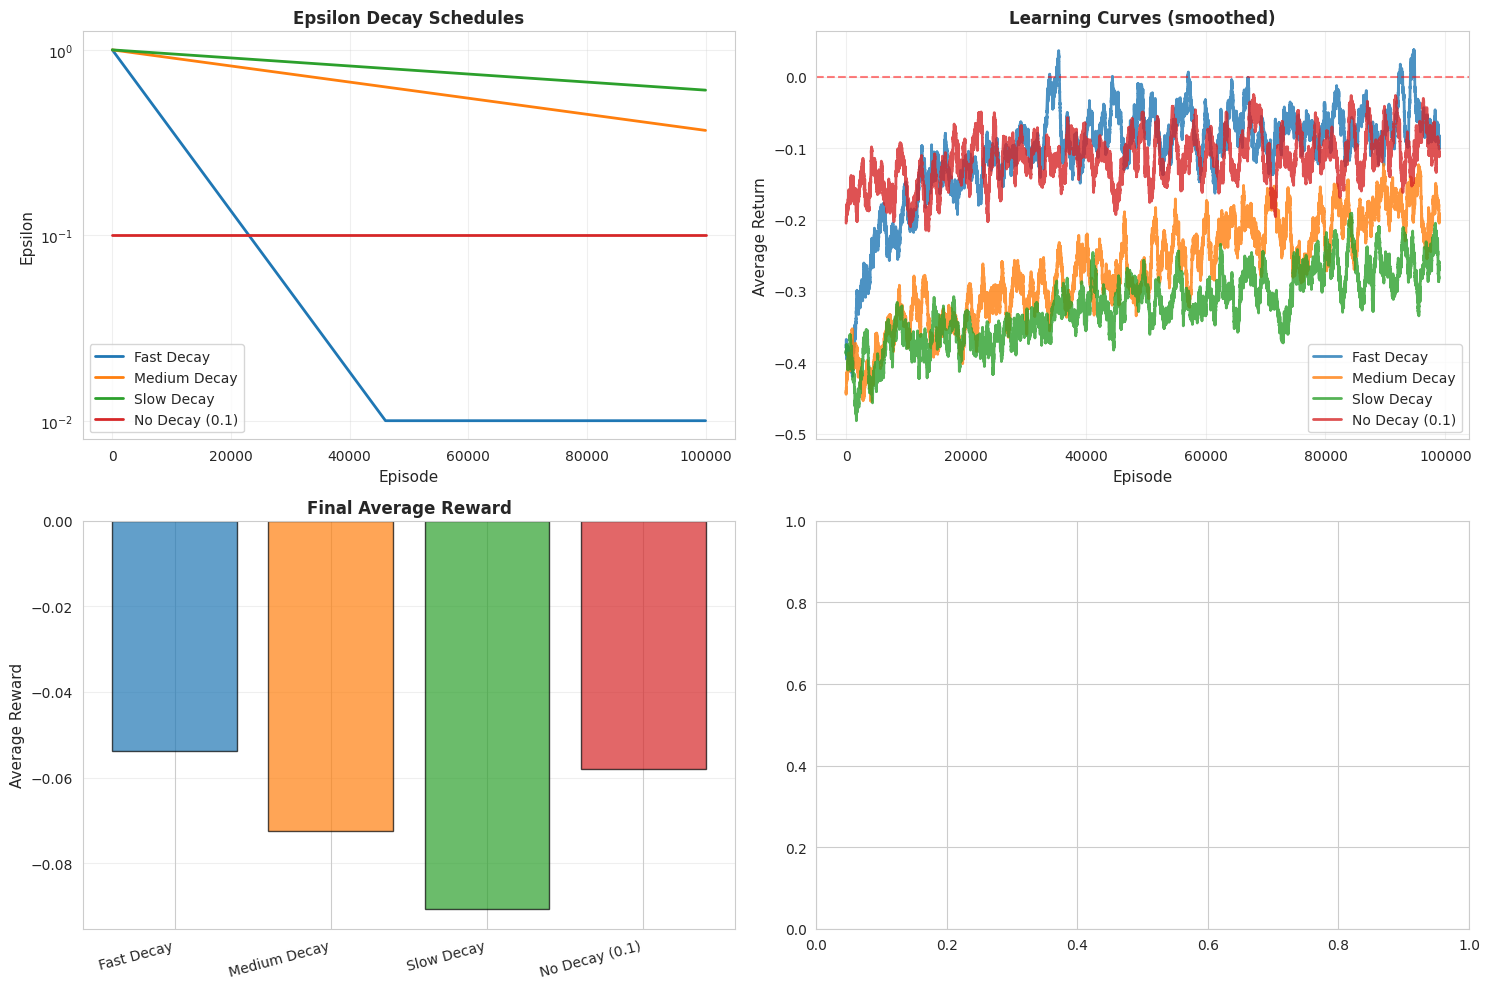


DECAY SCHEDULE COMPARISON SUMMARY

Fast Decay:
  Average Reward: -0.0538
  Win Rate: 43.02%

Medium Decay:
  Average Reward: -0.0726
  Win Rate: 42.94%

Slow Decay:
  Average Reward: -0.0908
  Win Rate: 41.96%

No Decay (0.1):
  Average Reward: -0.0580
  Win Rate: 42.82%


In [17]:
def experiment_decay_schedules(env, num_episodes=100000):
    """
    Compare different epsilon decay schedules.
    """
    decay_configs = {
        'Fast Decay': {'start': 1.0, 'end': 0.01, 'decay': 0.9999},
        'Medium Decay': {'start': 1.0, 'end': 0.01, 'decay': 0.99999},
        'Slow Decay': {'start': 1.0, 'end': 0.01, 'decay': 0.999995},
        'No Decay (0.1)': {'start': 0.1, 'end': 0.1, 'decay': 1.0},
    }

    results = {}

    print("Experimenting with different decay schedules...")
    print("=" * 60)

    for name, config in decay_configs.items():
        print(f"\nTraining with {name}")

        Q_temp, policy_temp, stats_temp = mc_control_first_visit(
            env,
            num_episodes=num_episodes,
            epsilon_start=config['start'],
            epsilon_end=config['end'],
            epsilon_decay=config['decay'],
            gamma=1.0
        )

        # Evaluate
        rewards_temp, avg_reward_temp, win_rate_temp = evaluate_policy(
            env, policy_temp, num_episodes=5000, epsilon=0.0
        )

        results[name] = {
            'avg_reward': avg_reward_temp,
            'win_rate': win_rate_temp,
            'training_returns': stats_temp['episode_returns'],
            'epsilon_schedule': stats_temp['epsilon_values']
        }

    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Epsilon schedules
    ax = axes[0, 0]
    for name, data in results.items():
        eps_schedule = data['epsilon_schedule']
        sample_indices = np.linspace(0, len(eps_schedule)-1, 1000, dtype=int)
        ax.plot(sample_indices, [eps_schedule[i] for i in sample_indices],
                label=name, linewidth=2)
    ax.set_xlabel('Episode', fontsize=11)
    ax.set_ylabel('Epsilon', fontsize=11)
    ax.set_title('Epsilon Decay Schedules', fontsize=12, fontweight='bold')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Learning curves
    ax = axes[0, 1]
    for name, data in results.items():
        returns = data['training_returns']
        smoothed = np.convolve(returns, np.ones(1000)/1000, mode='valid')
        ax.plot(smoothed, label=name, linewidth=2, alpha=0.8)
    ax.set_xlabel('Episode', fontsize=11)
    ax.set_ylabel('Average Return', fontsize=11)
    ax.set_title('Learning Curves (smoothed)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Plot 3: Final performance - Average Reward
    ax = axes[1, 0]
    names = list(results.keys())
    avg_rewards = [results[n]['avg_reward'] for n in names]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    ax.bar(range(len(names)), avg_rewards, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Average Reward', fontsize=11)
    ax.set_title('Final Average Reward', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=15, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "=" * 60)
    print("DECAY SCHEDULE COMPARISON SUMMARY")
    print("=" * 60)
    for name in names:
        print(f"\n{name}:")
        print(f"  Average Reward: {results[name]['avg_reward']:.4f}")
        print(f"  Win Rate: {results[name]['win_rate']:.2f}%")

    return results

# Run decay schedule experiments
decay_results = experiment_decay_schedules(env, num_episodes=100000)

State-Action Visit Frequency Analysis
Total unique states visited: 280
  With usable ace: 100
  Without usable ace: 180

Q-value Statistics:
  Mean: -0.2239
  Std: 0.4168
  Min: -1.0000
  Max: 0.9445

Top 10 Best States (highest value):
  (21, 9, 1): V=0.945, Policy=Stick
  (21, 8, 0): V=0.936, Policy=Stick
  (21, 8, 1): V=0.935, Policy=Stick
  (21, 9, 0): V=0.930, Policy=Stick
  (21, 7, 1): V=0.929, Policy=Stick
  (21, 7, 0): V=0.918, Policy=Stick
  (21, 6, 1): V=0.900, Policy=Stick
  (21, 10, 1): V=0.893, Policy=Stick
  (21, 5, 0): V=0.892, Policy=Stick
  (21, 6, 0): V=0.890, Policy=Stick

Top 10 Worst States (lowest value):
  (16, 10, 0): V=-0.574, Policy=Stick
  (13, 1, 0): V=-0.576, Policy=Hit
  (14, 10, 0): V=-0.577, Policy=Stick
  (15, 10, 0): V=-0.587, Policy=Stick
  (14, 1, 0): V=-0.594, Policy=Hit
  (4, 1, 0): V=-0.603, Policy=Hit
  (4, 10, 0): V=-0.617, Policy=Stick
  (17, 1, 0): V=-0.628, Policy=Stick
  (15, 1, 0): V=-0.642, Policy=Hit
  (16, 1, 0): V=-0.659, Policy=Hit


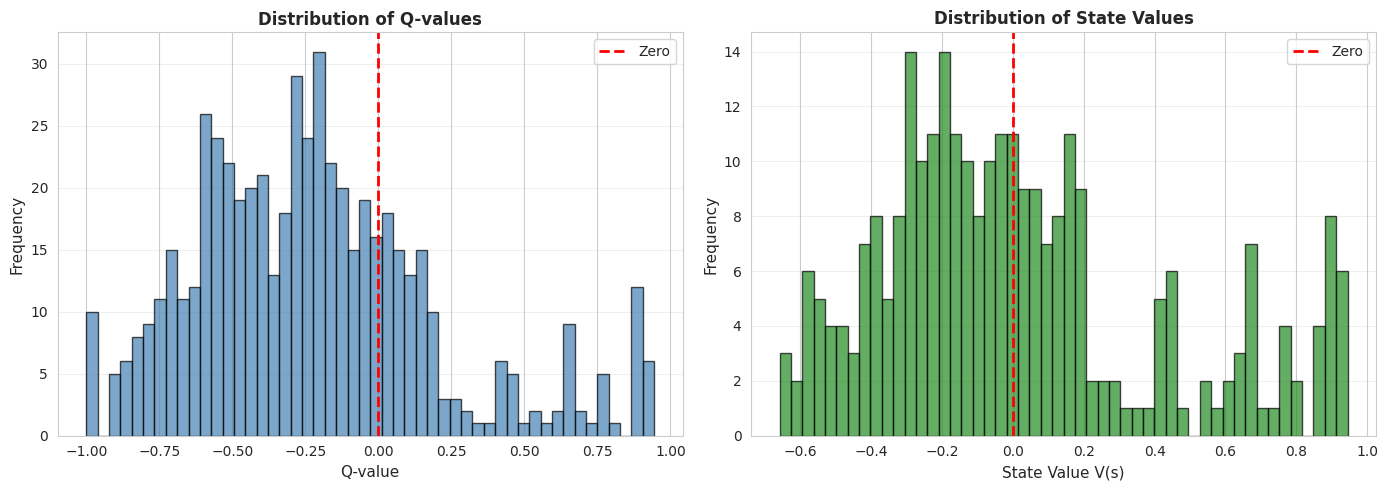

In [18]:
def analyze_visit_frequencies(Q, policy):
    """
    Analyze which states and actions were visited most frequently.
    """
    print("State-Action Visit Frequency Analysis")
    print("=" * 60)

    # Count states by characteristics
    usable_ace_states = sum(1 for s in Q.keys() if s[2] == True)
    no_ace_states = sum(1 for s in Q.keys() if s[2] == False)

    print(f"Total unique states visited: {len(Q)}")
    print(f"  With usable ace: {usable_ace_states}")
    print(f"  Without usable ace: {no_ace_states}")
    print()

    # Analyze Q-values
    all_q_values = []
    for state in Q:
        all_q_values.extend(Q[state])

    print("Q-value Statistics:")
    print(f"  Mean: {np.mean(all_q_values):.4f}")
    print(f"  Std: {np.std(all_q_values):.4f}")
    print(f"  Min: {np.min(all_q_values):.4f}")
    print(f"  Max: {np.max(all_q_values):.4f}")
    print()

    # Best and worst states
    V = get_value_function(Q)
    sorted_states = sorted(V.items(), key=lambda x: x[1], reverse=True)

    print("Top 10 Best States (highest value):")
    for state, value in sorted_states[:10]:
        action = policy[state]
        action_name = 'Hit' if action == 1 else 'Stick'
        print(f"  {state}: V={value:.3f}, Policy={action_name}")

    print("\nTop 10 Worst States (lowest value):")
    for state, value in sorted_states[-10:]:
        action = policy[state]
        action_name = 'Hit' if action == 1 else 'Stick'
        print(f"  {state}: V={value:.3f}, Policy={action_name}")

    # Plot Q-value distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Q-value histogram
    ax = axes[0]
    ax.hist(all_q_values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Q-value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Q-values', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Plot 2: Value function histogram
    ax = axes[1]
    values = list(V.values())
    ax.hist(values, bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
    ax.set_xlabel('State Value V(s)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of State Values', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

analyze_visit_frequencies(Q, greedy_policy)

### Monte Carlo vs Random Policy Comparison

Evaluating Random Policy Baseline...


Random Policy: 100%|██████████| 10000/10000 [00:01<00:00, 9632.38it/s]



Random Policy Results:
  Average Reward: -0.3897
  Win Rate: 28.39%


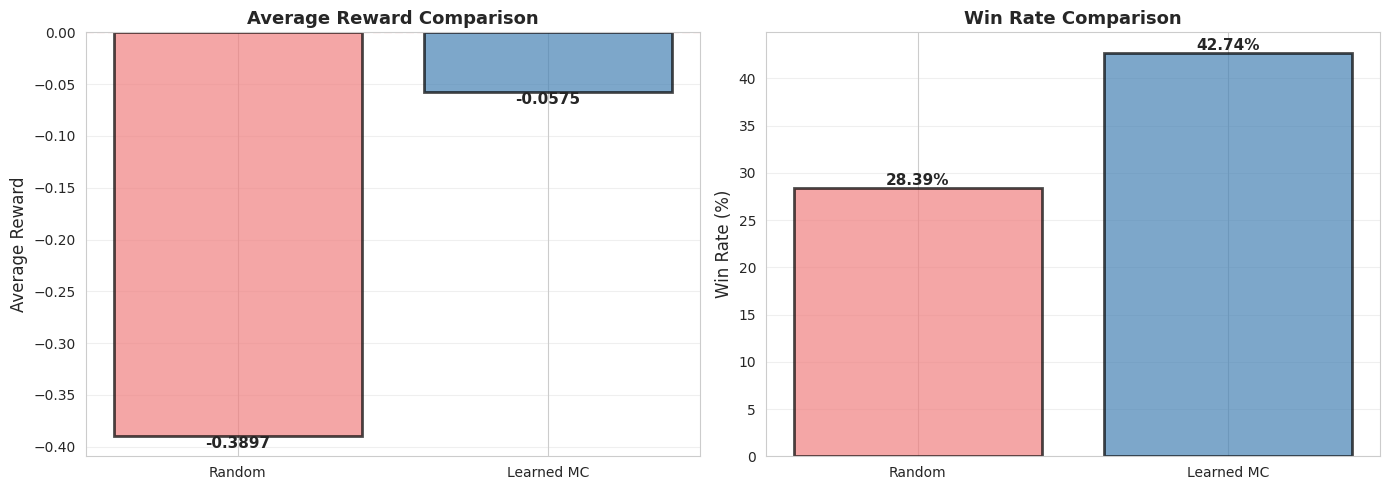


Improvement over Random Policy:
  Average Reward: +0.3322 (85.2% better)
  Win Rate: +14.35 percentage points


In [19]:
def random_policy_baseline(env, num_episodes=10000):
    """
    Evaluate a completely random policy as baseline.
    """
    print("Evaluating Random Policy Baseline...")

    rewards = []
    wins = 0
    losses = 0
    draws = 0

    for _ in tqdm(range(num_episodes), desc="Random Policy"):
        state, _ = env.reset()
        terminated = False
        episode_reward = 0

        while not terminated:
            action = env.action_space.sample()  # Random action
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state

        rewards.append(episode_reward)
        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = np.mean(rewards)
    win_rate = 100 * wins / num_episodes

    print(f"\nRandom Policy Results:")
    print(f"  Average Reward: {avg_reward:.4f}")
    print(f"  Win Rate: {win_rate:.2f}%")

    return avg_reward, win_rate

# Compare with learned policy
random_avg, random_win = random_policy_baseline(env, num_episodes=10000)

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average Reward Comparison
ax = axes[0]
policies = ['Random', 'Learned MC']
avg_rewards = [random_avg, avg_reward]
colors = ['lightcoral', 'steelblue']
bars = ax.bar(policies, avg_rewards, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('Average Reward Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Add value labels on bars
for bar, val in zip(bars, avg_rewards):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=11, fontweight='bold')

# Plot 2: Win Rate Comparison
ax = axes[1]
win_rates = [random_win, win_rate]
bars = ax.bar(policies, win_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Win Rate Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, win_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nImprovement over Random Policy:")
print(f"  Average Reward: {avg_reward - random_avg:+.4f} ({100*(avg_reward - random_avg)/abs(random_avg):.1f}% better)")
print(f"  Win Rate: {win_rate - random_win:+.2f} percentage points")

Convergence Analysis


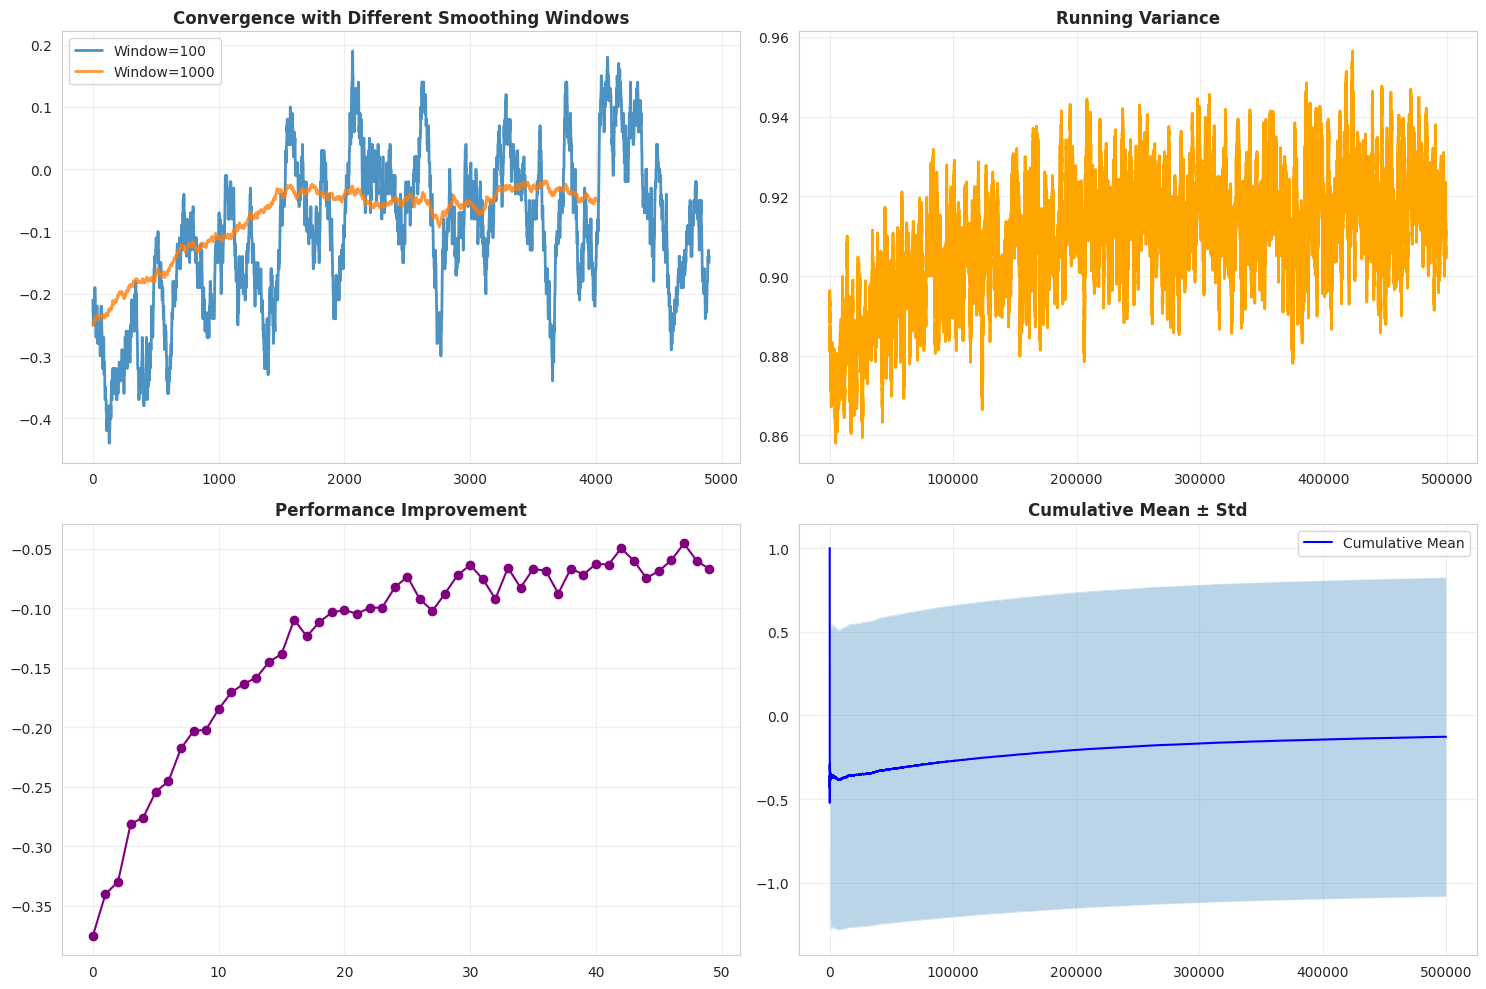

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_convergence(stats, window_sizes=[100, 1000, 10000], sample_rate=100):
    episode_returns = np.array(stats['episode_returns'])
    n = len(episode_returns)

    # Downsample for plotting
    sampled_returns = episode_returns[::sample_rate]

    print("Convergence Analysis")
    print("=" * 60)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # --- Smoothed curves ---
    ax = axes[0, 0]
    for window in window_sizes:
        if len(sampled_returns) >= window:
            smoothed = np.convolve(sampled_returns, np.ones(window)/window, mode='valid')
            ax.plot(smoothed, label=f'Window={window}', linewidth=2, alpha=0.8)
    ax.set_title('Convergence with Different Smoothing Windows', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # --- Running variance (vectorized, not loop) ---
    window = 1000
    if len(episode_returns) > window:
        var_series = np.convolve((episode_returns - np.mean(episode_returns))**2,
                                 np.ones(window)/window, mode='valid')
        axes[0, 1].plot(var_series, color='orange', linewidth=2)
    axes[0, 1].set_title('Running Variance', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # --- Chunk averages ---
    chunk_size = 10000
    chunks = [episode_returns[i:i+chunk_size] for i in range(0, n, chunk_size)]
    chunk_avgs = [np.mean(c) for c in chunks if len(c)]
    axes[1, 0].plot(chunk_avgs, marker='o', color='purple')
    axes[1, 0].set_title('Performance Improvement', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # --- Cumulative mean and std (vectorized) ---
    cumulative_mean = np.cumsum(episode_returns) / (np.arange(n) + 1)
    rolling_std = np.sqrt(np.cumsum((episode_returns - cumulative_mean)**2) / (np.arange(n) + 1))
    axes[1, 1].plot(cumulative_mean, label='Cumulative Mean', color='blue')
    axes[1, 1].fill_between(range(len(cumulative_mean)), cumulative_mean - rolling_std,
                            cumulative_mean + rolling_std, alpha=0.3)
    axes[1, 1].set_title('Cumulative Mean ± Std', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
analyze_convergence(stats)

In [23]:
def print_final_summary(Q, policy, stats, V):
    """
    Print comprehensive summary of the training results.
    """
    print("\n" + "=" * 70)
    print(" " * 20 + "FINAL TRAINING SUMMARY")
    print("=" * 70)

    print("\n1. TRAINING CONFIGURATION")
    print("-" * 70)
    print(f"   Total Episodes: {len(stats['episode_returns']):,}")
    print(f"   Discount Factor (γ): 1.0")
    print(f"   Initial Epsilon: {stats['epsilon_values'][0]:.4f}")
    print(f"   Final Epsilon: {stats['epsilon_values'][-1]:.4f}")

    print("\n2. STATE SPACE COVERAGE")
    print("-" * 70)
    print(f"   Unique states visited: {len(Q):,}")
    print(f"   Theoretical max states: ~280 (for common game states)")
    print(f"   Coverage: ~{100*len(Q)/280:.1f}%")

    print("\n3. LEARNING PERFORMANCE")
    print("-" * 70)
    episode_returns = stats['episode_returns']
    print(f"   Initial 10k episodes avg: {np.mean(episode_returns[:10000]):.4f}")
    print(f"   Final 10k episodes avg: {np.mean(episode_returns[-10000:]):.4f}")
    print(f"   Overall average return: {np.mean(episode_returns):.4f}")
    print(f"   Best 10k window avg: {max([np.mean(episode_returns[i:i+10000]) for i in range(0, len(episode_returns)-10000, 10000)]):.4f}")

    print("\n4. VALUE FUNCTION STATISTICS")
    print("-" * 70)
    values = list(V.values())
    print(f"   Mean state value: {np.mean(values):.4f}")
    print(f"   Std of state values: {np.std(values):.4f}")
    print(f"   Min state value: {np.min(values):.4f}")
    print(f"   Max state value: {np.max(values):.4f}")

    print("\n5. POLICY CHARACTERISTICS")
    print("-" * 70)
    stick_count = sum(1 for a in policy.values() if a == 0)
    hit_count = sum(1 for a in policy.values() if a == 1)
    print(f"   States where policy says STICK: {stick_count} ({100*stick_count/len(policy):.1f}%)")
    print(f"   States where policy says HIT: {hit_count} ({100*hit_count/len(policy):.1f}%)")

    print("\n" + "=" * 70)
    print()

print_final_summary(Q, greedy_policy, stats, V)


                    FINAL TRAINING SUMMARY

1. TRAINING CONFIGURATION
----------------------------------------------------------------------
   Total Episodes: 500,000
   Discount Factor (γ): 1.0
   Initial Epsilon: 1.0000
   Final Epsilon: 0.0100

2. STATE SPACE COVERAGE
----------------------------------------------------------------------
   Unique states visited: 280
   Theoretical max states: ~280 (for common game states)
   Coverage: ~100.0%

3. LEARNING PERFORMANCE
----------------------------------------------------------------------
   Initial 10k episodes avg: -0.3752
   Final 10k episodes avg: -0.0669
   Overall average return: -0.1279
   Best 10k window avg: -0.0454

4. VALUE FUNCTION STATISTICS
----------------------------------------------------------------------
   Mean state value: 0.0136
   Std of state values: 0.3983
   Min state value: -0.6588
   Max state value: 0.9445

5. POLICY CHARACTERISTICS
----------------------------------------------------------------------